In [103]:
from openai import OpenAI
import os
import pandas as pd
from datasets import load_dataset
import random
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from dotenv import load_dotenv
load_dotenv()

OPENAI_API_KEY = os.getenv("P_OPENAI_API_KEY")
client = OpenAI(api_key=OPENAI_API_KEY)
SEED = 42

random.seed(SEED)

In [105]:
# Import the ClassLabel module to represent categorical class labels
from datasets import ClassLabel

# Loading the 'app reviews' dataset's training split into the dataset variable
dataset = load_dataset("app_reviews")

# converting the 'star' column in the dataset to a ClassLabel type
# This allows for categorical representation and easier handling of classes
dataset = dataset.class_encode_column("star")

# Displaying the dataset to see the changes
dataset

DatasetDict({
    train: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 288065
    })
})

In [106]:
# splitting the dataset into a train and test set
# reserve 20% of the data for testing and use stratification on the 'star' column
# to ensure both sets have equal proportion of each start category
dataset = dataset['train'].train_test_split(test_size=0.2, seed=SEED, stratify_by_column="star")

# Assign the training and validation sets to their respective keys
dataset["train"] = dataset['train']
dataset["test"] = dataset['test']

# Now, split the training set to reserve 25% of the data for validation
df = dataset["train"].train_test_split(test_size=0.25, seed=SEED, stratify_by_column="star")

# Assigning the split datasets to their respective keys:
# The remaining 75% of the inintial data becomes the new training data
dataset["train"] = df["train"]

# The remaining 25% of the inintial data becomes the new validation data
dataset["validation"] = df["test"]

# Displaying the dataset to see the changes
dataset

DatasetDict({
    train: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
    validation: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
})

In [107]:
dataset['train']

Dataset({
    features: ['package_name', 'review', 'date', 'star'],
    num_rows: 172839
})

In [108]:
# Convert to pandas dataframe
training_df = pd.DataFrame(dataset['train'])

training_df.head()

,package_name,review,date,star
0,org.ppsspp.ppsspp,Nice😉,March 09 2017,4
1,com.google.android.gms,Google play service Just one ward its amazing ...,December 18 2016,4
2,com.google.android.gms,Mr Perfect,April 30 2017,0
3,org.torproject.android,Does not work with Tmobile S4 If you try to in...,September 08 2016,0
4,com.google.android.gms,Ok,April 29 2017,2


In [109]:
training_df['review'].sample(5)

156820    People who can t set it up the bios and games ...
29508            Really good Efficient and effective! Nice!
53019                                Nice It is very iseful
100053                  Its geat to give other people ideas
112989                                      Super Very good
Name: review, dtype: object

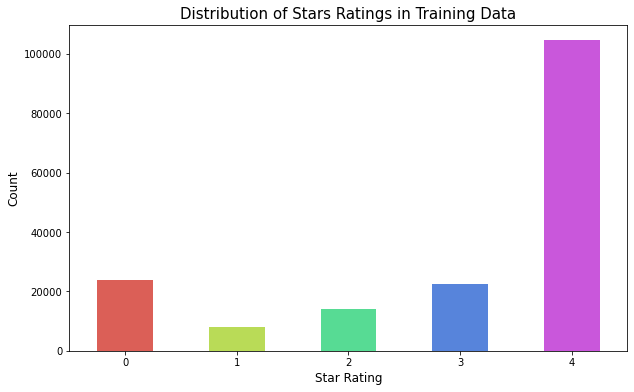

In [110]:
# Counting the number of occurences for each 'star' value, sorting by index
star_counts = training_df['star'].value_counts().sort_index()

# creating the bar plot to show the distribution of star ratings given
plt.figure(figsize=(10, 6))
star_counts.plot(kind='bar', color=sns.color_palette('hls', len(star_counts)))

# Adding titles and labels for clarity
plt.title('Distribution of Stars Ratings in Training Data', fontsize=15)
plt.xlabel('Star Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)

# Displaying the plot
plt.show()

In [111]:
test_df = pd.DataFrame(dataset['test'])
val_df = pd.DataFrame(dataset['validation'])

### Sentiment Prediction (Star Column)

In [112]:
# Creating the 'prompt' column in each dataset (train, test, and validation) by adding a seperator '###\n' to the 'review' column
# This seperator is often used in fine-tuning to signal where the prompts ends and the expected output begins.
training_df['prompt'] = training_df['review'] + '\n###\n'
test_df['prompt'] = test_df['review'] + '\n###\n'
val_df['prompt'] = val_df['review'] + '\n###\n'

In [113]:
training_df['prompt'].head()

0                                         Nice😉\n###\n
1    Google play service Just one ward its amazing ...
2                                    Mr Perfect\n###\n
3    Does not work with Tmobile S4 If you try to in...
4                                            Ok\n###\n
Name: prompt, dtype: object

In [114]:
# Converting the 'star' column in each dataset to a string format and storing it in the 'completion' column
# The 'completion' column will be used as the target variable for sentiment analysis
training_df['completion'] = training_df['star'].astype(str)
test_df['completion'] = test_df['star'].astype(str)
val_df['completion'] = val_df['star'].astype(str)

In [115]:
# Creating a dataset in JSONL format after dropping duplicates based on the 'prompt`
# Random sampling to ensure the data is shuffled
training_df.sample(
    len(training_df),
).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].to_json(
    "app-review-full-train-sentiment-random.jsonl", orient="records", lines=True
)

In [116]:
# Creating another version of the dataset in JSONL format, but this time ordering by the 'completion' column (star rating)
# This ordered set might be useful for specific training strategies
training_df.sample(
    len(training_df)
).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].sort_values(by='completion').to_json(
    "app-review-full-train-sentiment-ordered.jsonl", orient="records", lines=True
)

In [117]:
# Creating a validation dataset in JSONL format after dropping duplicates based on the 'prompt' column
val_df.sample(
    len(val_df)
).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].to_json(
    "app-review-full-val-sentiment-random.jsonl", orient="records", lines=True
)

# Creating a test dataset in JSONL format after dropping duplicates based on the 'prompt' column
test_df.sample(
    len(test_df),
).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].to_json(
    "app-review-full-test-sentiment-random.jsonl", orient="records", lines=True
)

In [118]:
training_df.head()

,package_name,review,date,star,prompt,completion
0,org.ppsspp.ppsspp,Nice😉,March 09 2017,4,Nice😉\n###\n,4
1,com.google.android.gms,Google play service Just one ward its amazing ...,December 18 2016,4,Google play service Just one ward its amazing ...,4
2,com.google.android.gms,Mr Perfect,April 30 2017,0,Mr Perfect\n###\n,0
3,org.torproject.android,Does not work with Tmobile S4 If you try to in...,September 08 2016,0,Does not work with Tmobile S4 If you try to in...,0
4,com.google.android.gms,Ok,April 29 2017,2,Ok\n###\n,2


In [119]:
def get_data_dict(row, system=''):
    return {
        "message": [
            {"role": "system", "content": system},
            {"role": "user", "content": row['review']},
            {"role": "assistant", "content": str(row['star'])}
        ]
    }

### Using OpenAI's Fine-tuning API

In [120]:
import json

In [121]:
# reminder of what the data looks like
json.loads(open('app-review-full-train-sentiment-random.jsonl', 'rb').readline())

{'prompt': "Lightweight  functional and ad-free. UI size and layout isn't very customizable  but that isn't an issue for me.\n###\n",
 'completion': '4'}

In [122]:
# Creating a file object for the training dataset with OpenAI's API
# The 'file' parameter specifies the path to the training data in JSONL format
# The purpose is to set to 'fine-tune', indicating the file's intended use
training_file = client.files.create(
    file=open("app-review-full-train-sentiment-random.jsonl", 'rb'),
    purpose='fine-tune'
)

# Creating a file object for the validation dataset with OpenAI's API
val_file = client.files.create(
    file=open("app-review-full-val-sentiment-random.jsonl", 'rb'),
    purpose='fine-tune'
)

In [123]:
# Initiating the fine-tuning process with OpenAI's API

# The openai.FineTune.create method is used to start the training process
# Parameters include:
# training_file: The ID of the previously uploaded training dataset file 
# validation_file: The ID of the previously uploaded validation dataset file
# model: The base model to be fine-tuned. In this case, 'babbage-002' is used
# hyperparameters: A dictionary of hyperparameters to fine-tune. Here, we specify the number of epochs as 1

job = client.fine_tuning.jobs.create(
    training_file=training_file.id,
    validation_file=val_file.id,
    model='babbage-002',
    hyperparameters={'n_epochs': 1}
)

BadRequestError: Error code: 400 - {'error': {'message': 'Fine-tuning jobs cannot be created on an Explore plan. You can upgrade to a paid plan on your billing page: https://platform.openai.com/account/billing/overview', 'type': 'invalid_request_error', 'param': None, 'code': 'exceeded_quota'}}

In [88]:
training_file

FileObject(id='file-DmagUg9syrmK14FuBpU2RVta', bytes=15979754, created_at=1713971385, filename='app-review-full-train-sentiment-random.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)